In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

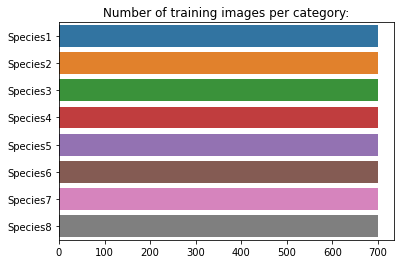

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


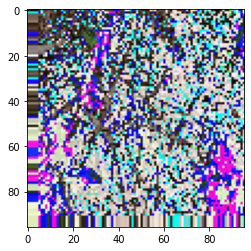

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

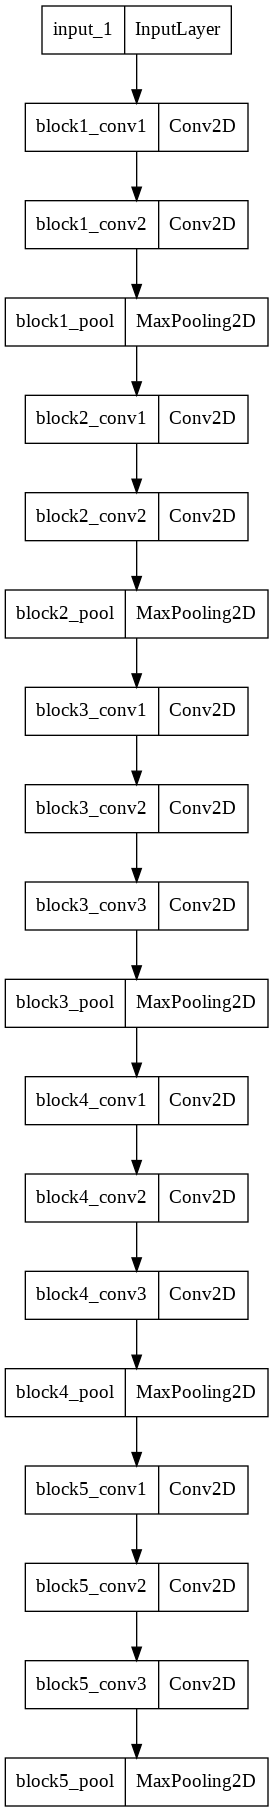

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 3.0095 - accuracy: 0.4148 - precision: 0.4724 - recall: 0.3121 

175/175 [==============================] - 2932s 17s/step - loss: 3.0095 - accuracy: 0.4148 - precision: 0.4724 - recall: 0.3121 - val_loss: 1.2939 - val_accuracy: 0.5028 - val_precision: 0.7440 - val_recall: 0.2922
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.5163 - precision: 0.6387 - recall: 0.3675

175/175 [==============================] - 27s 156ms/step - loss: 1.3675 - accuracy: 0.5163 - precision: 0.6387 - recall: 0.3675 - val_loss: 1.1922 - val_accuracy: 0.5218 - val_precision: 0.6973 - val_recall: 0.3454
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.5627 - precision: 0.6892 - recall: 0.4254

175/175 [==============================] - 27s 154ms/step - loss: 1.2055 - accuracy: 0.5627 - precision: 0.6892 - recall: 0.4254 - val_loss: 1.1086 - val_accuracy: 0.5806 - val_precision: 0.7668 - val_recall: 0.4118
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.5973 - precision: 0.7120 - recall: 0.4579

175/175 [==============================] - 27s 156ms/step - loss: 1.1337 - accuracy: 0.5973 - precision: 0.7120 - recall: 0.4579 - val_loss: 1.0899 - val_accuracy: 0.5787 - val_precision: 0.7054 - val_recall: 0.4497
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.6152 - precision: 0.7343 - recall: 0.4921

175/175 [==============================] - 28s 160ms/step - loss: 1.0617 - accuracy: 0.6152 - precision: 0.7343 - recall: 0.4921 - val_loss: 1.0385 - val_accuracy: 0.5958 - val_precision: 0.7284 - val_recall: 0.4630
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.6395 - precision: 0.7468 - recall: 0.5304

175/175 [==============================] - 27s 157ms/step - loss: 0.9853 - accuracy: 0.6395 - precision: 0.7468 - recall: 0.5304 - val_loss: 1.0230 - val_accuracy: 0.6072 - val_precision: 0.7018 - val_recall: 0.5047
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.6502 - precision: 0.7522 - recall: 0.5377

175/175 [==============================] - 27s 156ms/step - loss: 0.9715 - accuracy: 0.6502 - precision: 0.7522 - recall: 0.5377 - val_loss: 0.9980 - val_accuracy: 0.6053 - val_precision: 0.7451 - val_recall: 0.5047
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6587 - precision: 0.7607 - recall: 0.5529

175/175 [==============================] - 27s 155ms/step - loss: 0.9361 - accuracy: 0.6587 - precision: 0.7607 - recall: 0.5529 - val_loss: 1.0140 - val_accuracy: 0.6110 - val_precision: 0.7408 - val_recall: 0.4991
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.8899 - accuracy: 0.6711 - precision: 0.7749 - recall: 0.5729

175/175 [==============================] - 27s 157ms/step - loss: 0.8899 - accuracy: 0.6711 - precision: 0.7749 - recall: 0.5729 - val_loss: 1.0277 - val_accuracy: 0.6091 - val_precision: 0.7247 - val_recall: 0.4896
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.6816 - precision: 0.7856 - recall: 0.5836

175/175 [==============================] - 27s 155ms/step - loss: 0.8807 - accuracy: 0.6816 - precision: 0.7856 - recall: 0.5836 - val_loss: 0.9748 - val_accuracy: 0.6243 - val_precision: 0.7507 - val_recall: 0.5199
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.6800 - precision: 0.7766 - recall: 0.5830

175/175 [==============================] - 27s 155ms/step - loss: 0.8791 - accuracy: 0.6800 - precision: 0.7766 - recall: 0.5830 - val_loss: 0.9842 - val_accuracy: 0.6148 - val_precision: 0.7111 - val_recall: 0.5370
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.6993 - precision: 0.7882 - recall: 0.6034

175/175 [==============================] - 27s 155ms/step - loss: 0.8346 - accuracy: 0.6993 - precision: 0.7882 - recall: 0.6034 - val_loss: 0.9746 - val_accuracy: 0.6395 - val_precision: 0.7411 - val_recall: 0.5541
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.7021 - precision: 0.7871 - recall: 0.6121

175/175 [==============================] - 28s 160ms/step - loss: 0.8212 - accuracy: 0.7021 - precision: 0.7871 - recall: 0.6121 - val_loss: 1.0167 - val_accuracy: 0.6034 - val_precision: 0.7197 - val_recall: 0.5066
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.8036 - accuracy: 0.7079 - precision: 0.7984 - recall: 0.6273

175/175 [==============================] - 27s 153ms/step - loss: 0.8036 - accuracy: 0.7079 - precision: 0.7984 - recall: 0.6273 - val_loss: 0.9938 - val_accuracy: 0.6414 - val_precision: 0.7266 - val_recall: 0.5294
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.7091 - precision: 0.7922 - recall: 0.6243

175/175 [==============================] - 28s 159ms/step - loss: 0.8165 - accuracy: 0.7091 - precision: 0.7922 - recall: 0.6243 - val_loss: 0.9322 - val_accuracy: 0.6546 - val_precision: 0.7628 - val_recall: 0.5370
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.7719 - accuracy: 0.7229 - precision: 0.7998 - recall: 0.6405

175/175 [==============================] - 27s 155ms/step - loss: 0.7719 - accuracy: 0.7229 - precision: 0.7998 - recall: 0.6405 - val_loss: 0.9645 - val_accuracy: 0.6281 - val_precision: 0.7367 - val_recall: 0.5522
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.7177 - precision: 0.7957 - recall: 0.6309

175/175 [==============================] - 27s 156ms/step - loss: 0.7900 - accuracy: 0.7177 - precision: 0.7957 - recall: 0.6309 - val_loss: 0.9065 - val_accuracy: 0.6603 - val_precision: 0.7670 - val_recall: 0.5560
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.7280 - precision: 0.8088 - recall: 0.6434

175/175 [==============================] - 27s 156ms/step - loss: 0.7659 - accuracy: 0.7280 - precision: 0.8088 - recall: 0.6434 - val_loss: 0.9052 - val_accuracy: 0.6490 - val_precision: 0.7357 - val_recall: 0.5598
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.7284 - precision: 0.8035 - recall: 0.6529

175/175 [==============================] - 28s 158ms/step - loss: 0.7552 - accuracy: 0.7284 - precision: 0.8035 - recall: 0.6529 - val_loss: 0.9201 - val_accuracy: 0.6471 - val_precision: 0.7443 - val_recall: 0.5579
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.7261 - precision: 0.8034 - recall: 0.6545

175/175 [==============================] - 28s 160ms/step - loss: 0.7342 - accuracy: 0.7261 - precision: 0.8034 - recall: 0.6545 - val_loss: 0.9675 - val_accuracy: 0.6376 - val_precision: 0.7346 - val_recall: 0.5674
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.7314 - precision: 0.8072 - recall: 0.6566

175/175 [==============================] - 28s 158ms/step - loss: 0.7397 - accuracy: 0.7314 - precision: 0.8072 - recall: 0.6566 - val_loss: 0.9291 - val_accuracy: 0.6509 - val_precision: 0.7507 - val_recall: 0.5427
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.7336 - precision: 0.8159 - recall: 0.6579

175/175 [==============================] - 27s 154ms/step - loss: 0.7361 - accuracy: 0.7336 - precision: 0.8159 - recall: 0.6579 - val_loss: 0.9616 - val_accuracy: 0.6452 - val_precision: 0.7353 - val_recall: 0.5693
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7430 - precision: 0.8181 - recall: 0.6721

175/175 [==============================] - 27s 155ms/step - loss: 0.7168 - accuracy: 0.7430 - precision: 0.8181 - recall: 0.6721 - val_loss: 1.0188 - val_accuracy: 0.6224 - val_precision: 0.7366 - val_recall: 0.5465
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.7462 - precision: 0.8153 - recall: 0.6718

175/175 [==============================] - 27s 154ms/step - loss: 0.7322 - accuracy: 0.7462 - precision: 0.8153 - recall: 0.6718 - val_loss: 0.9442 - val_accuracy: 0.6679 - val_precision: 0.7618 - val_recall: 0.5825
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.7496 - precision: 0.8271 - recall: 0.6784

175/175 [==============================] - 27s 155ms/step - loss: 0.7125 - accuracy: 0.7496 - precision: 0.8271 - recall: 0.6784 - val_loss: 1.0263 - val_accuracy: 0.6167 - val_precision: 0.7239 - val_recall: 0.5522
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7527 - precision: 0.8288 - recall: 0.6855

175/175 [==============================] - 27s 155ms/step - loss: 0.7010 - accuracy: 0.7527 - precision: 0.8288 - recall: 0.6855 - val_loss: 1.0105 - val_accuracy: 0.6376 - val_precision: 0.7333 - val_recall: 0.5636
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.7427 - precision: 0.8166 - recall: 0.6695

175/175 [==============================] - 27s 155ms/step - loss: 0.6943 - accuracy: 0.7427 - precision: 0.8166 - recall: 0.6695 - val_loss: 0.9440 - val_accuracy: 0.6452 - val_precision: 0.7537 - val_recall: 0.5750
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.7466 - precision: 0.8209 - recall: 0.6795

175/175 [==============================] - 28s 162ms/step - loss: 0.7105 - accuracy: 0.7466 - precision: 0.8209 - recall: 0.6795 - val_loss: 0.9427 - val_accuracy: 0.6641 - val_precision: 0.7650 - val_recall: 0.5560
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.7498 - precision: 0.8170 - recall: 0.6823

175/175 [==============================] - 27s 155ms/step - loss: 0.7019 - accuracy: 0.7498 - precision: 0.8170 - recall: 0.6823 - val_loss: 0.9300 - val_accuracy: 0.6490 - val_precision: 0.7457 - val_recall: 0.5731
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.7586 - precision: 0.8239 - recall: 0.6893

175/175 [==============================] - 27s 155ms/step - loss: 0.6727 - accuracy: 0.7586 - precision: 0.8239 - recall: 0.6893 - val_loss: 0.9672 - val_accuracy: 0.6433 - val_precision: 0.7209 - val_recall: 0.5636
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.7661 - precision: 0.8324 - recall: 0.7023

175/175 [==============================] - 27s 156ms/step - loss: 0.6568 - accuracy: 0.7661 - precision: 0.8324 - recall: 0.7023 - val_loss: 0.9360 - val_accuracy: 0.6679 - val_precision: 0.7438 - val_recall: 0.5731
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7621 - precision: 0.8334 - recall: 0.6934

175/175 [==============================] - 27s 154ms/step - loss: 0.6676 - accuracy: 0.7621 - precision: 0.8334 - recall: 0.6934 - val_loss: 0.9496 - val_accuracy: 0.6717 - val_precision: 0.7488 - val_recall: 0.5769
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7698 - precision: 0.8352 - recall: 0.7030

175/175 [==============================] - 27s 156ms/step - loss: 0.6575 - accuracy: 0.7698 - precision: 0.8352 - recall: 0.7030 - val_loss: 0.9638 - val_accuracy: 0.6471 - val_precision: 0.7332 - val_recall: 0.5787
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.7563 - precision: 0.8226 - recall: 0.6964

175/175 [==============================] - 27s 154ms/step - loss: 0.6722 - accuracy: 0.7563 - precision: 0.8226 - recall: 0.6964 - val_loss: 0.9197 - val_accuracy: 0.6755 - val_precision: 0.7459 - val_recall: 0.6015
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7634 - precision: 0.8255 - recall: 0.7002

175/175 [==============================] - 27s 156ms/step - loss: 0.6681 - accuracy: 0.7634 - precision: 0.8255 - recall: 0.7002 - val_loss: 0.9457 - val_accuracy: 0.6490 - val_precision: 0.7389 - val_recall: 0.6015
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7680 - precision: 0.8313 - recall: 0.7068

175/175 [==============================] - 28s 159ms/step - loss: 0.6492 - accuracy: 0.7680 - precision: 0.8313 - recall: 0.7068 - val_loss: 0.9461 - val_accuracy: 0.6565 - val_precision: 0.7390 - val_recall: 0.5750
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7707 - precision: 0.8336 - recall: 0.7093

175/175 [==============================] - 27s 155ms/step - loss: 0.6460 - accuracy: 0.7707 - precision: 0.8336 - recall: 0.7093 - val_loss: 0.9519 - val_accuracy: 0.6641 - val_precision: 0.7565 - val_recall: 0.6072
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7679 - precision: 0.8311 - recall: 0.7023

175/175 [==============================] - 27s 154ms/step - loss: 0.6635 - accuracy: 0.7679 - precision: 0.8311 - recall: 0.7023 - val_loss: 0.9995 - val_accuracy: 0.6338 - val_precision: 0.7245 - val_recall: 0.5787
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.7700 - precision: 0.8362 - recall: 0.7127

175/175 [==============================] - 27s 155ms/step - loss: 0.6480 - accuracy: 0.7700 - precision: 0.8362 - recall: 0.7127 - val_loss: 1.0103 - val_accuracy: 0.6641 - val_precision: 0.7302 - val_recall: 0.5958
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7796 - precision: 0.8413 - recall: 0.7188

175/175 [==============================] - 27s 153ms/step - loss: 0.6214 - accuracy: 0.7796 - precision: 0.8413 - recall: 0.7188 - val_loss: 0.9606 - val_accuracy: 0.6546 - val_precision: 0.7513 - val_recall: 0.5674
Epoch 41/200
175/175 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.7752 - precision: 0.8334 - recall: 0.7082

175/175 [==============================] - 30s 170ms/step - loss: 0.6449 - accuracy: 0.7752 - precision: 0.8334 - recall: 0.7082 - val_loss: 0.9567 - val_accuracy: 0.6603 - val_precision: 0.7258 - val_recall: 0.5825
Epoch 42/200
175/175 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.7793 - precision: 0.8439 - recall: 0.7232

175/175 [==============================] - 27s 153ms/step - loss: 0.6255 - accuracy: 0.7793 - precision: 0.8439 - recall: 0.7232 - val_loss: 0.9007 - val_accuracy: 0.6717 - val_precision: 0.7442 - val_recall: 0.6072
Epoch 43/200
175/175 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7736 - precision: 0.8372 - recall: 0.7098

175/175 [==============================] - 28s 162ms/step - loss: 0.6662 - accuracy: 0.7736 - precision: 0.8372 - recall: 0.7098 - val_loss: 0.9651 - val_accuracy: 0.6490 - val_precision: 0.7451 - val_recall: 0.5825
Epoch 44/200
175/175 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7829 - precision: 0.8480 - recall: 0.7261

175/175 [==============================] - 28s 160ms/step - loss: 0.6156 - accuracy: 0.7829 - precision: 0.8480 - recall: 0.7261 - val_loss: 0.9373 - val_accuracy: 0.6565 - val_precision: 0.7411 - val_recall: 0.5920


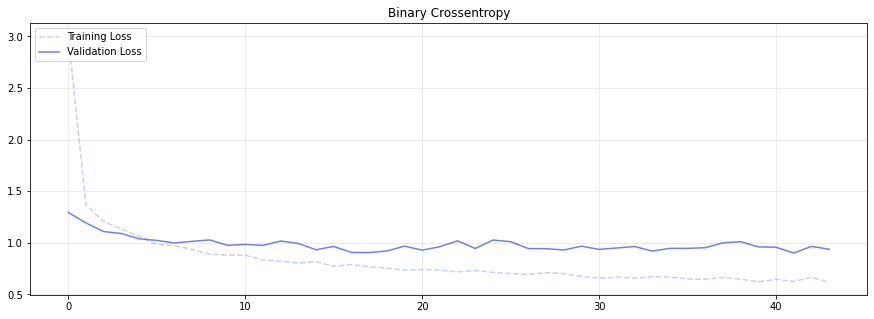

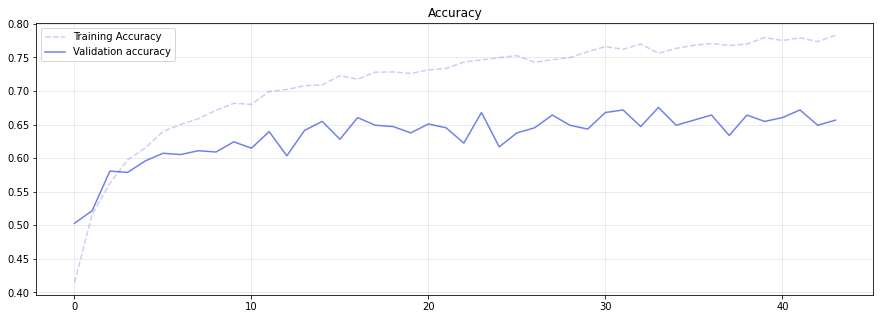

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [ ]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [ ]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:17]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0     

In [ ]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 25s 131ms/step - loss: 0.7141 - accuracy: 0.7559 - precision_1: 0.8179 - recall_1: 0.7043 - val_loss: 0.9561 - val_accuracy: 0.6641 - val_precision_1: 0.7584 - val_recall_1: 0.6015
Epoch 2/200
175/175 [==============================] - 22s 126ms/step - loss: 0.6664 - accuracy: 0.7800 - precision_1: 0.8410 - recall_1: 0.7246 - val_loss: 1.0402 - val_accuracy: 0.6622 - val_precision_1: 0.7500 - val_recall_1: 0.5920
Epoch 3/200
175/175 [==============================] - 22s 126ms/step - loss: 0.6119 - accuracy: 0.7957 - precision_1: 0.8544 - recall_1: 0.7420 - val_loss: 0.9345 - val_accuracy: 0.6622 - val_precision_1: 0.7500 - val_recall_1: 0.5750
Epoch 4/200
175/175 [==============================] - 22s 126ms/step - loss: 0.5995 - accuracy: 0.7941 - precision_1: 0.8531 - recall_1: 0.7362 - val_loss: 0.9532 - val_accuracy: 0.6793 - val_precision_1: 0.7564 - val_recall_1: 0.6186
Epoch 5/200
175/175 [==============================] - 2

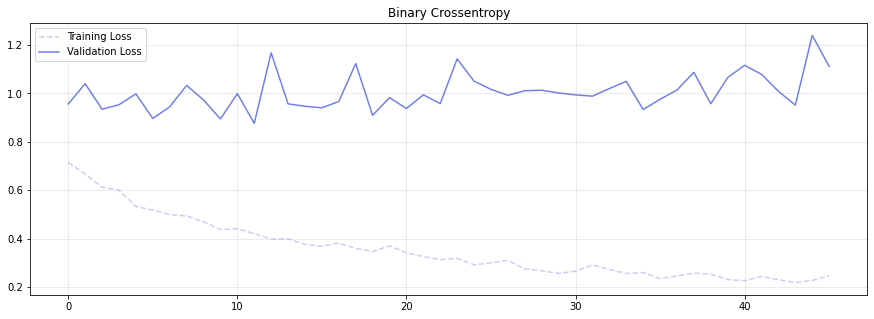

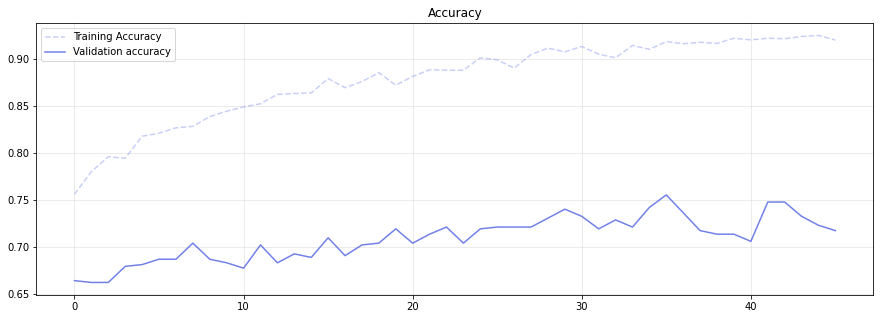

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [ ]:
tl_model.save('Vgg16/Tuned_v1_1')

In [ ]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 181s 16s/step - loss: 1.1034 - accuracy: 0.7618 - precision_1: 0.7882 - recall_1: 0.7424

Test metrics
{'loss': 1.103385090827942, 'accuracy': 0.761772871017456, 'precision_1': 0.7882353067398071, 'recall_1': 0.742382287979126}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7618
Precision: 0.7569
Recall: 0.7391
F1: 0.7451


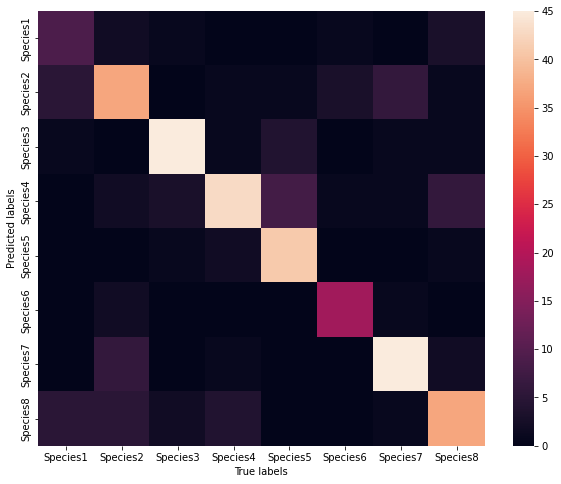

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()